# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras import initializers
import tensorflow.keras.backend as K
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score

# Set Environment

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU') 

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data-set Loading

In [2]:
df_train = pd.read_csv('train_features.csv')
df_test = pd.read_csv('test_features.csv')
df_train_terget = pd.read_csv("train_targets_scored.csv")

In [3]:
train = pd.merge(df_train,df_train_terget, how='inner',on='sig_id')
X_train = train[df_train.columns[1:]]
Y_train = train[df_train_terget.columns[1:]]

# DATA Pre-Processing

In [15]:
num_cols = list(df_train.describe().columns)

non_num_cols = [ ]
for i in df_train.columns[1:]:
    if i not in num_cols:
        non_num_cols.append(i)

# for i in non_num_cols:
#        print(df_train[i].value_counts())

In [16]:
 columns = [i for i in range(877)]

In [17]:
columns_transformer1 = ColumnTransformer(
    transformers=[
        ('encoder',OneHotEncoder(sparse=False),non_num_cols)
    ],
    remainder='passthrough'
    )
columns_transformer2 = ColumnTransformer(
    transformers=[
        ('nomalizer',StandardScaler(),columns)
    ],
    remainder='passthrough'
    )

# Construct Model

In [28]:
num_class = 206
input_shape = 877
l_rate = 0.01
batch_size = 64
fully_connected_units=[1024,512]
kernel_initializer = initializers.GlorotNormal()
bias_initializer = initializers.Zeros()
l2_regulizer = keras.regularizers.l2()
l1_regulaizer = keras.regularizers.l1()

In [29]:
p_min = 0.001
p_max = 0.999
def logloss(y_true,y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -K.mean(y_true*K.log(y_pred) + (1-y_true)*K.log(1-y_pred))

        

In [30]:
def MyModel(optimizer=keras.optimizers.Adam,l_rate=1e-3,inter_activation='relu'):
    '''
    args:
            optimizer : keras optimizers
            l_rate : learning rate
            inter_activation : activation fuction applied in hidden layer
    '''
    
    inputs = layers.Input(shape=(877))
    x = inputs
    x1 = layers.Dense(units=1024,activation=inter_activation)(x)
    x2 = layers.Dense(units=2048,activation=inter_activation)(x1)
    x3 = layers.Dense(units=1024,activation=inter_activation)(x2)
    x = layers.BatchNormalization()(x3)
    y = layers.Dense(kernel_regularizer=l2_regulizer,units=num_class,activation='sigmoid')(x)    
    model = keras.Model(inputs=inputs,outputs=y)
    model.compile(optimizer=optimizer(l_rate),loss=keras.losses.BinaryCrossentropy(),metrics=['binary_crossentropy'],)
    
    return model

In [31]:
preprocessor = Pipeline(steps=
                     [
                         ('encoder',columns_transformer1),
                         ('normalizer',columns_transformer2)
                     ])

In [32]:
def train_test_model(X_train,Y_train,batch_size=32,epochs=10,validation_split=0.1,call_backs=None,
                     optimizer=keras.optimizers.Adam,l_rate=1e-3,inter_activation='selu',**args):
    '''
    args:
            X_train: X
            Y_train: labels
            batch_size: size of the batch(defalut 32)
            epochs: number of epochs to be trained
            validation_split : fraction of validation set from X_train
            call_backs : callbacks
            optimizer : keras optimizers
            l_rate : learning rate
            inter_activation : activation fuction applied in hidden layer
            **agrs: any other param for fit method
    '''
    model = MyModel(optimizer=optimizer,l_rate=l_rate,inter_activation=inter_activation)
    history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,validation_split=validation_split,
                        callbacks=call_backs,**args)
    
    return history,model        

In [33]:
callback = tf.keras.callbacks.EarlyStopping(patience=3)
X = preprocessor.fit_transform(X_train)
history,model = train_test_model(X,Y_train,call_backs=[callback],inter_activation='relu',epochs=100,**{'verbose':2})

Epoch 1/100
670/670 - 28s - loss: 0.3733 - binary_crossentropy: 0.1853 - val_loss: 0.1339 - val_binary_crossentropy: 0.0664
Epoch 2/100
670/670 - 31s - loss: 0.1070 - binary_crossentropy: 0.0534 - val_loss: 0.0860 - val_binary_crossentropy: 0.0423
Epoch 3/100
670/670 - 28s - loss: 0.0760 - binary_crossentropy: 0.0387 - val_loss: 0.0660 - val_binary_crossentropy: 0.0340
Epoch 4/100
670/670 - 30s - loss: 0.0604 - binary_crossentropy: 0.0320 - val_loss: 0.0552 - val_binary_crossentropy: 0.0304
Epoch 5/100
670/670 - 28s - loss: 0.0507 - binary_crossentropy: 0.0281 - val_loss: 0.0466 - val_binary_crossentropy: 0.0271
Epoch 6/100
670/670 - 30s - loss: 0.0439 - binary_crossentropy: 0.0255 - val_loss: 0.0409 - val_binary_crossentropy: 0.0241
Epoch 7/100
670/670 - 26s - loss: 0.0388 - binary_crossentropy: 0.0236 - val_loss: 0.0372 - val_binary_crossentropy: 0.0238
Epoch 8/100
670/670 - 27s - loss: 0.0350 - binary_crossentropy: 0.0222 - val_loss: 0.0336 - val_binary_crossentropy: 0.0220
Epoch 9/

In [34]:
import matplotlib.pyplot as plt

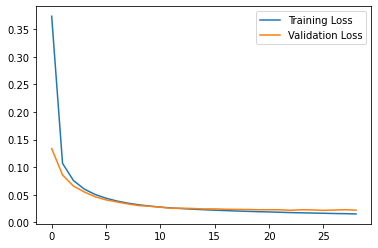

In [35]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 877)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              899072    
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_9 (Dense)              (None, 206)               211150    
Total params: 5,311,694
Trainable params: 5,309,646
Non-trainable params: 2,048
_______________________________________________